## 1. 保存模型并打包整个流程，同时计算AUC并绘制ROC曲线

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier  # 使用 scikeras 替代 keras.wrappers.scikit_learn
import joblib

In [ ]:
# 使用 TensorFlow/Keras 构建 DNN 模型，模型架构可以根据数据的复杂度进行调整。
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# 构建 DNN 模型的函数，用于在 Pipeline 中创建模型
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # 编译模型
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# # 对于多分类问题（类别数大于 2），可以将输出层调整为使用 softmax 激活函数：
# # 多分类问题输出层
# model.add(Dense(num_classes, activation='softmax'))

# # 编译模型，损失函数使用 categorical_crossentropy
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 加载数据
file_path = 'Data_01_training_20251215.xlsx'
data = pd.read_excel(file_path)

In [ ]:
data

,CRCID,Status,F1,F163,F488,F495,F496,F531,F544,F545,...,F9975,F9979,F9981,F9985,F9987,F9988,F9990,F9992,F9994,F9999
0,CRC0001,Benign,0.375309,0.000032,0.000024,0.000027,0.000023,1.07188,0.80212,0.66476,...,14.251554,11.846971,13.019938,26.362443,14.544796,18.767479,10.087520,5.454298,15.395197,3.086506
1,CRC0002,Benign,0.339877,0.000025,0.000021,0.000028,0.000022,0.96098,0.79746,0.60300,...,19.598487,6.182287,16.124934,24.856618,4.652649,11.153611,4.047167,13.479935,5.162528,3.113270
2,CRC0003,Benign,0.361105,0.000030,0.000023,0.000028,0.000023,0.92194,0.73428,0.59899,...,21.035867,16.706840,15.969301,20.041794,7.952584,6.285107,11.736475,2.212614,5.772037,2.992162
3,CRC0004,Benign,0.344177,0.000024,0.000023,0.000023,0.000021,0.87101,0.78669,0.68106,...,43.727821,10.390769,22.282428,25.774881,0.000000,12.353470,3.030641,8.889881,5.772650,3.027692
4,CRC0005,Benign,0.350482,0.000023,0.000020,0.000023,0.000021,0.88528,0.75012,0.60760,...,49.881906,9.945302,13.581553,15.259823,3.232223,24.987571,4.444307,0.870214,5.594232,3.169805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,CRC0314,Malignant,0.266566,0.000024,0.000017,0.000017,0.000015,0.87474,0.75824,0.66571,...,22.221553,5.704566,20.932655,16.230565,7.136675,13.581164,3.532535,1.790136,9.356443,3.208022
304,CRC0321,Malignant,0.369308,0.000017,0.000014,0.000015,0.000015,0.90041,0.78375,0.65140,...,27.346403,8.196040,10.691629,25.244854,0.000000,7.985885,1.786316,10.481474,0.000000,3.094635
305,CRC0322,Malignant,0.361974,0.000021,0.000016,0.000017,0.000016,0.96077,0.71310,0.59435,...,20.221259,11.805612,22.046624,17.661005,1.706835,17.518769,0.758594,3.532201,3.555907,3.121910
306,CRC0323,Malignant,0.426946,0.000013,0.000012,0.000012,0.000010,1.02567,0.78776,0.63218,...,25.010580,6.897449,15.748849,28.840325,3.302178,12.094960,7.972122,5.177972,5.705538,3.054486


In [ ]:
data = data.fillna(0)

In [ ]:
# 准备数据
X = data.loc[:, "F1":"F9999"]  # 从F1到F9999的特征
y = data['Status'].apply(lambda x: 1 if x == 'Malignant' else 0)  # 将status转换为二进制
groups = data['CRCID']  # 组信息

In [ ]:
print(f'Original X shape: {X.shape}')
print(f'Original y shape: {y.shape}')

Original X shape: (308, 443)
Original y shape: (308,)


In [ ]:
# from sklearn.impute import SimpleImputer

# # 用均值填补缺失值
# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(X)

# X = X.dropna()
# y = y[X.index]

In [ ]:
# 数据归一化： 通常，DNN 模型对归一化后的数据效果更好。使用 StandardScaler 将数据缩放。
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# 准备数据（假设 X_scaled 是归一化后的特征，y 是标签，groups 是组信息）
X, y = X_scaled, y
groups = data['CRCID']  # 组信息

In [ ]:
# 设置 StratifiedKFold 参数
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# 创建一个标准化和模型的 pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 标准化步骤
    ('dnn', KerasClassifier(model=create_model, epochs=50, batch_size=32, verbose=0))  # DNN 模型
])

In [ ]:
# # 训练模型
# # 参数解释：

# # epochs=50：模型迭代训练 50 次。
# # batch_size=32：每次使用 32 个样本进行梯度更新。
# # validation_split=0.2：使用 20% 的训练数据作为验证集。
# model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

In [ ]:
# 存储每个折叠的 AUC 曲线数据
tprs = []
mean_fpr = np.linspace(0, 1, 100)
fold_results = []

In [ ]:
# 存储AUC数据
auc_scores = []
# 用于存储结果
accuracies = []
f1_scores = []
y_true_all = []
y_pred_all = []
y_prob_all = []
group_all = []

In [ ]:
# 执行交叉验证
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    group_test = groups.iloc[test_index]
    
    # 训练 pipeline
    pipeline.fit(X_train, y_train)

    # 预测概率和分类结果
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    # 保存真实值、预测值、概率和组信息
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    y_prob_all.extend(y_prob)
    group_all.extend(groups.iloc[test_index])

    # 计算各项指标
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    
    TN, FP, FN, TP = cm.ravel()  # 根据数据调整解包顺序
    sensitivity = TP / (TP + FN)  # 同时也称为Recall
    specificity = TN / (TN + FP)
    ppv = TP / (TP + FP)  # 正预测值
    npv = TN / (TN + FN)  # 负预测值

    # 计算Benign和Malignant的数量
    benign_count = np.sum(y_test == 0)
    malignant_count = np.sum(y_test == 1)
    
    # 找出当Specificity = 0.9和0.95时的y_prob阈值
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # 查找特定的阈值
    threshold_90 = thresholds[np.argmax(fpr <= 0.1)]  # Specificity = 0.9
    threshold_95 = thresholds[np.argmax(fpr <= 0.05)] # Specificity = 0.95
    
    # 输出各项指标
    print(f'Fold Results:')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'AUC: {auc:.3f}')
    print(f'PPV: {ppv:.3f}')
    print(f'NPV: {npv:.3f}')
    print(f'Sensitivity: {sensitivity:.3f}')
    print(f'Specificity: {specificity:.3f}')
    print(f'Benign count: {benign_count}')
    print(f'Malignant count: {malignant_count}')
    print(f'y_prob threshold when Specificity=0.9: {threshold_90:.3f}')
    print(f'y_prob threshold when Specificity=0.95: {threshold_95:.3f}')
    print('-' * 40)

c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold Results:
Accuracy: 0.742
AUC: 0.819
PPV: 0.714
NPV: 0.765
Sensitivity: 0.714
Specificity: 0.765
Benign count: 17
Malignant count: 14
y_prob threshold when Specificity=0.9: inf
y_prob threshold when Specificity=0.95: inf
----------------------------------------


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold Results:
Accuracy: 0.871
AUC: 0.933
PPV: 0.812
NPV: 0.933
Sensitivity: 0.929
Specificity: 0.824
Benign count: 17
Malignant count: 14
y_prob threshold when Specificity=0.9: inf
y_prob threshold when Specificity=0.95: inf
----------------------------------------


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold Results:
Accuracy: 0.806
AUC: 0.899
PPV: 0.750
NPV: 0.867
Sensitivity: 0.857
Specificity: 0.765
Benign count: 17
Malignant count: 14
y_prob threshold when Specificity=0.9: inf
y_prob threshold when Specificity=0.95: inf
----------------------------------------


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold Results:
Accuracy: 0.742
AUC: 0.853
PPV: 0.875
NPV: 0.696
Sensitivity: 0.500
Specificity: 0.941
Benign count: 17
Malignant count: 14
y_prob threshold when Specificity=0.9: inf
y_prob threshold when Specificity=0.95: inf
----------------------------------------


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold Results:
Accuracy: 0.774
AUC: 0.871
PPV: 0.900
NPV: 0.714
Sensitivity: 0.600
Specificity: 0.938
Benign count: 16
Malignant count: 15
y_prob threshold when Specificity=0.9: inf
y_prob threshold when Specificity=0.95: inf
----------------------------------------


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold Results:
Accuracy: 0.839
AUC: 0.946
PPV: 0.917
NPV: 0.789
Sensitivity: 0.733
Specificity: 0.938
Benign count: 16
Malignant count: 15
y_prob threshold when Specificity=0.9: inf
y_prob threshold when Specificity=0.95: inf
----------------------------------------


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold Results:
Accuracy: 0.806
AUC: 0.938
PPV: 0.846
NPV: 0.778
Sensitivity: 0.733
Specificity: 0.875
Benign count: 16
Malignant count: 15
y_prob threshold when Specificity=0.9: inf
y_prob threshold when Specificity=0.95: inf
----------------------------------------


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold Results:
Accuracy: 0.806
AUC: 0.887
PPV: 0.800
NPV: 0.812
Sensitivity: 0.800
Specificity: 0.812
Benign count: 16
Malignant count: 15
y_prob threshold when Specificity=0.9: inf
y_prob threshold when Specificity=0.95: inf
----------------------------------------


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold Results:
Accuracy: 0.800
AUC: 0.826
PPV: 0.900
NPV: 0.750
Sensitivity: 0.643
Specificity: 0.938
Benign count: 16
Malignant count: 14
y_prob threshold when Specificity=0.9: inf
y_prob threshold when Specificity=0.95: inf
----------------------------------------


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold Results:
Accuracy: 0.900
AUC: 0.987
PPV: 0.867
NPV: 0.933
Sensitivity: 0.929
Specificity: 0.875
Benign count: 16
Malignant count: 14
y_prob threshold when Specificity=0.9: inf
y_prob threshold when Specificity=0.95: inf
----------------------------------------


In [ ]:
# 计算所有折的平均指标
average_accuracy = np.mean([accuracy_score(y_true_all, y_pred_all)])
average_auc = roc_auc_score(y_true_all, y_prob_all)
average_sensitivity = np.mean([sensitivity])
average_specificity = np.mean([specificity])
average_ppv = np.mean([ppv])
average_npv = np.mean([npv])

print(f'Overall Results:')
print(f'Average Accuracy: {average_accuracy:.3f}')
print(f'Average AUC: {average_auc:.3f}')
print(f'Average Sensitivity: {average_sensitivity:.3f}')
print(f'Average Specificity: {average_specificity:.3f}')
print(f'Average PPV: {average_ppv:.3f}')
print(f'Average NPV: {average_npv:.3f}')

Overall Results:
Average Accuracy: 0.808
Average AUC: 0.884
Average Sensitivity: 0.929
Average Specificity: 0.875
Average PPV: 0.867
Average NPV: 0.933


In [ ]:
# 显示平均结果
print("Average Accuracy:", sum(accuracies) / len(accuracies))
print("Average F1 Score:", sum(f1_scores) / len(f1_scores))

Average Accuracy: 0.808709677419355
Average F1 Score: 0.778439684198305


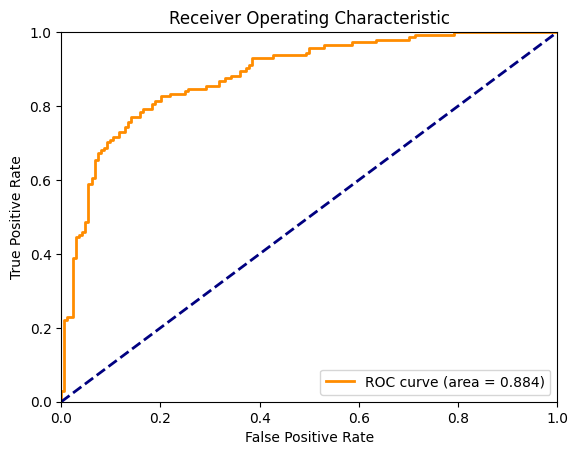

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true_all, y_prob_all)

# 使用roc_auc_score计算AUC
roc_auc = roc_auc_score(y_true_all, y_prob_all)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 保存Pipeline
pipeline_path = 'dnn_pipeline.pkl'
joblib.dump(pipeline, pipeline_path)

print(f"Pipeline saved to: {pipeline_path}")

Pipeline saved to: dnn_pipeline.pkl


In [ ]:
# 创建包含预测结果和组信息的数据框
results_df = pd.DataFrame({
    'Group': group_all,
    'True Status': y_true_all,
    'Predicted Status': y_pred_all,
    'Malignant Probability': y_prob_all
})

# 输出到Excel文件
output_path = '01_prediction_results.xlsx'
results_df.to_excel(output_path, index=False)

# 打印输出文件路径和AUC值
print(f"Results saved to: {output_path}")
print(f"AUC: {roc_auc:.3f}")

Results saved to: 01_prediction_results.xlsx
AUC: 0.884


In [ ]:
print(f'Original X shape: {X.shape}')
print(f'Original y shape: {y.shape}')

Original X shape: (308, 443)
Original y shape: (308,)


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


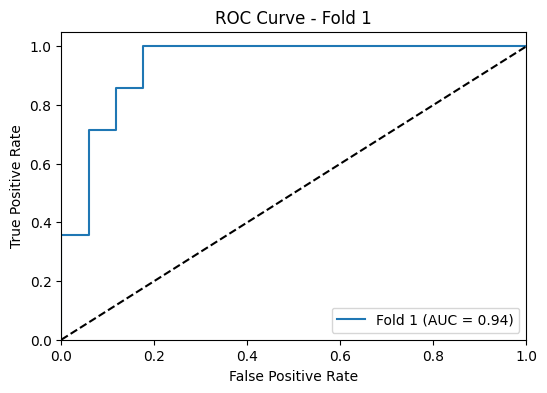

Saved fold_1.xlsx


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


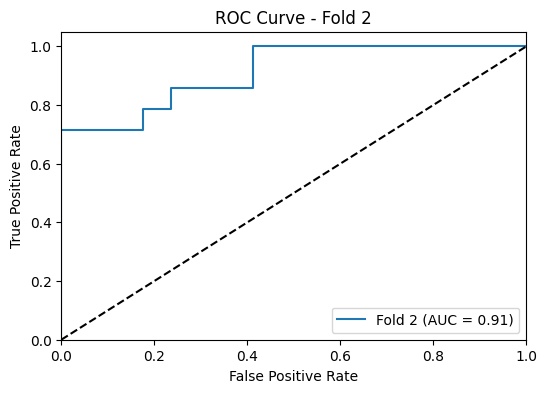

Saved fold_2.xlsx


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


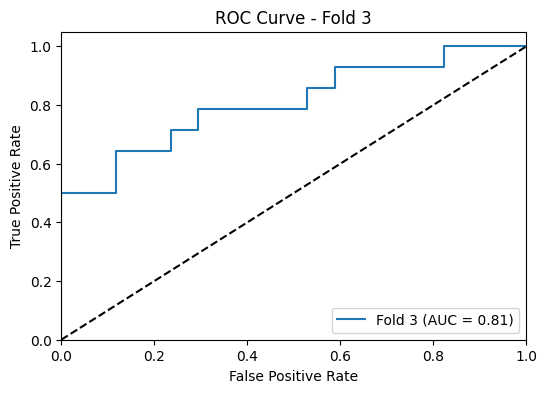

Saved fold_3.xlsx


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


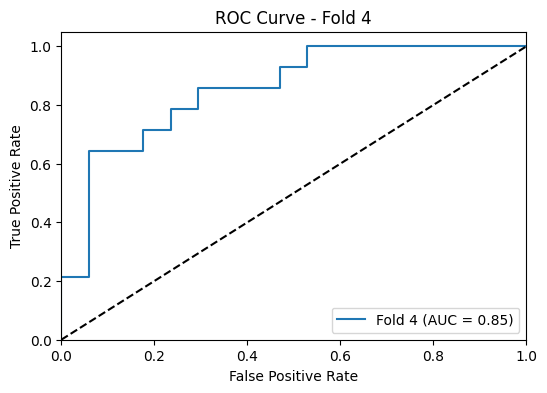

Saved fold_4.xlsx


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


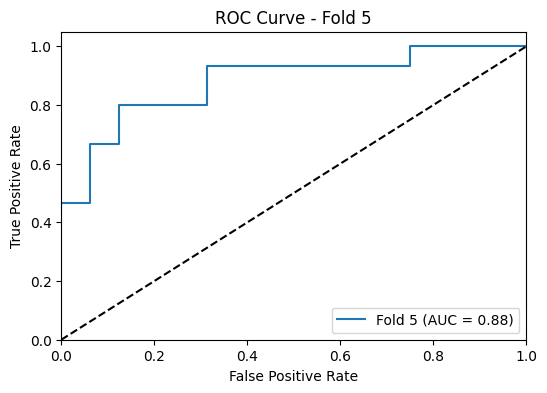

Saved fold_5.xlsx


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


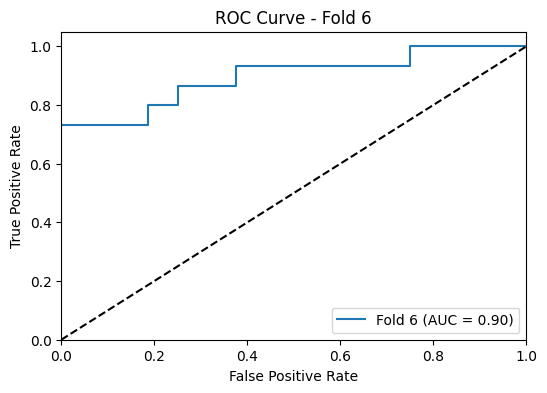

Saved fold_6.xlsx


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


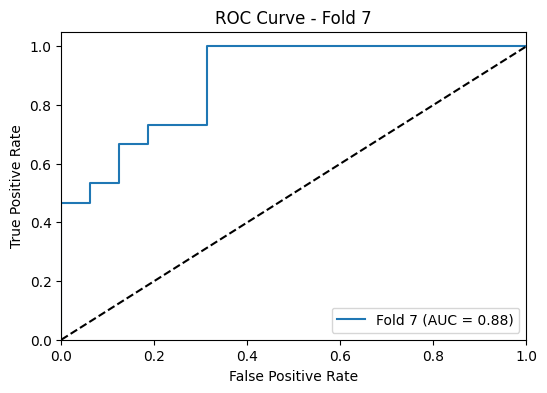

Saved fold_7.xlsx


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


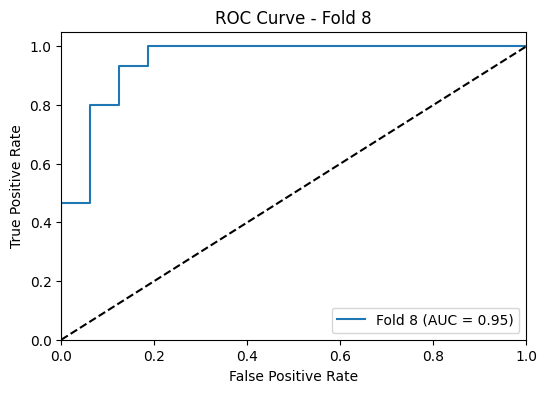

Saved fold_8.xlsx


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


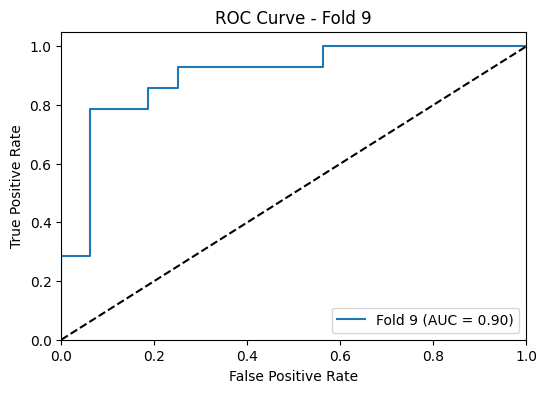

Saved fold_9.xlsx


c:\Users\xuewei\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


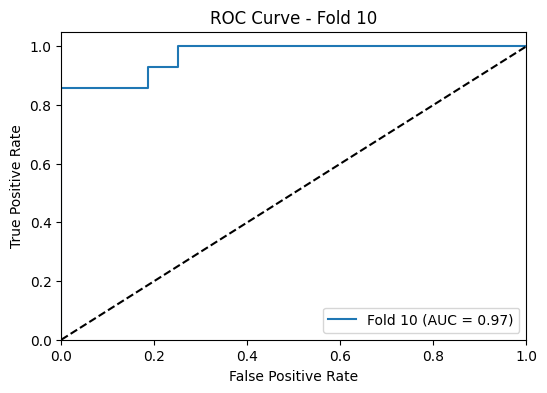

Saved fold_10.xlsx


In [ ]:
from sklearn.model_selection import StratifiedKFold

# 创建 StratifiedKFold 对象，指定折数
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # 这里的 n_splits=10 是折数，可以根据需要调整

# 循环交叉检验的每一折
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    group_test = groups.iloc[test_index]
    
    # 在每一折上训练模型
    pipeline.fit(X_train, y_train)
    
    # 获取预测值和预测概率
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # 对于二分类问题，如果是多分类问题需要调整
    
    # 构建DataFrame并添加列
    test_data = pd.DataFrame({
        'y_pred': y_pred,
        'y_prob': y_prob,
        'y_true': y_test,
        'group': groups.iloc[test_index]
    })

    # 计算ROC曲线和AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # 绘制每一折的ROC曲线
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'Fold {fold + 1} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Fold {fold + 1}')
    plt.legend(loc='lower right')
    plt.show()
    
    # 保存为Excel文件
    file_name = f'fold_{fold + 1}.xlsx'
    test_data.to_excel(file_name, index=False)
    print(f'Saved {file_name}')


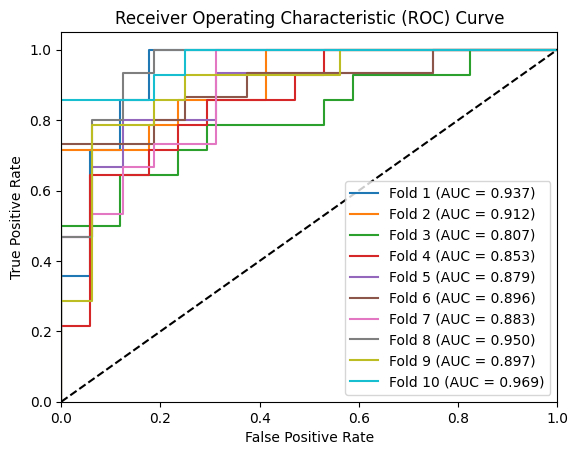

Average AUC: 0.898


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

auc_scores = []

for fold in range(10):
    try:
        # 读取每一折的真实值和预测概率
        df = pd.read_excel(f'fold_{fold + 1}.xlsx')
        y_true = df['y_true']
        y_prob = df['y_prob']
        
        # 计算 ROC 曲线
        fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=1)
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        
        # 绘制 ROC 曲线
        plt.plot(fpr, tpr, label=f'Fold {fold + 1} (AUC = {roc_auc:.3f})')
    except Exception as e:
        print(f"Error processing fold {fold + 1}: {e}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 输出平均AUC
print(f'Average AUC: {np.mean(auc_scores):.3f}')

## 2. 加载模型并预测新数据，同时计算AUC并绘制ROC曲线

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scikeras.wrappers import KerasClassifier  # 使用 scikeras 替代 keras.wrappers.scikit_learn
import joblib

In [ ]:
# 使用 TensorFlow/Keras 构建 DNN 模型，模型架构可以根据数据的复杂度进行调整。
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# 加载保存的Pipeline
pipeline_path = 'dnn_pipeline.pkl'
loaded_pipeline = joblib.load(pipeline_path)

In [ ]:
# 加载新的数据进行预测（假设已经有一个新的数据集）
new_data = pd.read_excel('Data_02_internal_20251215.xlsx')  # 示例数据集
new_data = new_data.fillna(0)

In [ ]:
# 准备数据
X_new = new_data.loc[:, "F1":"F9999"]  # 提取新数据中的特征
groups_new = new_data['CRCID']  # 组信息
y_true_new = new_data['Status'].apply(lambda x: 1 if x == 'Malignant' else 0)  # 真实状态

In [ ]:
scaler = StandardScaler()
X_scaled_new = scaler.fit_transform(X_new)

In [ ]:
# 使用加载的模型进行预测
y_pred_new = loaded_pipeline.predict(X_scaled_new)
y_prob_new = loaded_pipeline.predict_proba(X_scaled_new)[:, 1]  # 获取预测为malignant的概率

In [ ]:
# 计算ROC曲线并绘制
fpr_new, tpr_new, thresholds_new = roc_curve(y_true_new, y_prob_new)
roc_auc_new = auc(fpr_new, tpr_new)

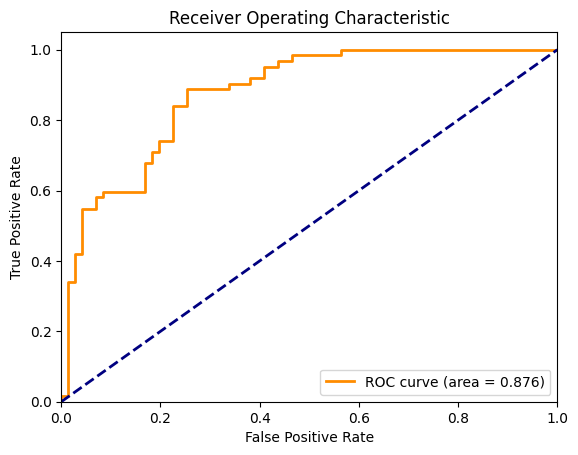

In [ ]:
plt.figure()
plt.plot(fpr_new, tpr_new, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_new)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 创建包含预测结果和组信息的数据框
results_new_df = pd.DataFrame({
    'Group': groups_new,
    'True Status': y_true_new,
    'Predicted Status': y_pred_new,
    'Malignant Probability': y_prob_new
})

In [ ]:
# 输出到Excel文件
output_new_path = '02_prediction_results.xlsx'
results_new_df.to_excel(output_new_path, index=False)

In [ ]:
# 打印输出文件路径和AUC值
print(f"Results for new data saved to: {output_new_path}")
print(f"AUC for new data: {roc_auc_new:.3f}")

Results for new data saved to: 02_prediction_results.xlsx
AUC for new data: 0.876
